# Overview

This notebook is used to simply explore model output files at the moment.  It follows the style of `drb_make_figs.py`.

In [2]:
import os
os.getcwd()

'c:\\Users\\tjame\\Desktop\\Research\\DRB\\DRB_water_management\\notebooks'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import datetime as dt
import sys
import h5py
import seaborn as sns

sys.path.append('../')

# Custom modules
from pywrdrb.utils.processing import get_base_results, get_pywr_results
from pywrdrb.plotting.plotting_functions import plot_3part_flows, plot_flow_contributions, plot_weekly_flow_distributions

In [4]:
### directories
output_dir = 'output_data/'
input_dir = 'input_data/'
fig_dir = 'figs/'

# Constants
cms_to_mgd = 22.82
cm_to_mg = 264.17/1e6
cfs_to_mgd = 0.0283 * 22824465.32 / 1e6


### list of reservoirs and major flow points to compare across models
reservoir_list = ['cannonsville', 'pepacton', 'neversink', 'wallenpaupack', 'prompton', 'shoholaMarsh', \
                   'mongaupeCombined', 'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', \
                   'assunpink', 'ontelaunee', 'stillCreek', 'blueMarsh', 'greenLane', 'marshCreek']
non_nyc_reservoirs = ['wallenpaupack', 'prompton', 'shoholaMarsh', \
                   'mongaupeCombined', 'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', \
                   'assunpink', 'ontelaunee', 'stillCreek', 'blueMarsh', 'greenLane', 'marshCreek']
trenton_reservoirs = ['wallenpaupack', 'prompton', 'shoholaMarsh', \
                   'mongaupeCombined', 'beltzvilleCombined', 'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', \
                   'assunpink']
majorflow_list = ['delLordville', 'delMontague', 'delTrenton', 'outletAssunpink', 'outletSchuylkill', 'outletChristina']

In [5]:
# Load pywr models
print('Retrieving simulation data.')
pywr_models = ['obs_pub', 'nhmv10', 'nwmv21', 'WEAP_23Aug2022_gridmet_nhmv10']
res_releases = {}
major_flows = {}
inflows = {}
storages = {}

for model in pywr_models:
    res_releases[f'pywr_{model}'] = get_pywr_results(output_dir, model, 'res_release')
    major_flows[f'pywr_{model}'] = get_pywr_results(output_dir, model, 'major_flow')
    storages[f'pywr_{model}'] = get_pywr_results(output_dir, model, 'res_storage')
    inflows[model] = get_pywr_results(output_dir, model, 'inflow')
pywr_models = [f'pywr_{m}' for m in pywr_models]

# Load base (non-pywr) models
base_models = ['obs', 'obs_pub', 'nhmv10', 'nwmv21', 'WEAP_23Aug2022_gridmet']
datetime_index = list(res_releases.values())[0].index
for model in base_models:
    res_releases[model] = get_base_results(input_dir, model, datetime_index, 'res_release')
    major_flows[model] = get_base_results(input_dir, model, datetime_index, 'major_flow')


Retrieving simulation data.


In [6]:
def get_pywr_results(output_dir, model, results_set='all', scenario=0):
    '''
    Gathers simulation results from Pywr model run and returns a pd.DataFrame.

    :param output_dir:
    :param model:
    :param results_set: can be "all" to return all results,
                            "res_release" to return reservoir releases (downstream gage comparison),
                            "res_storage" to return resrvoir storages,
                            "major_flow" to return flow at major flow points of interest,
                            "inflow" to return the inflow at each catchment.
    :return:
    '''
    with h5py.File(f'{output_dir}drb_output_{model}.hdf5', 'r') as f:
        keys = list(f.keys())
        first = 0
        results = pd.DataFrame()
        for k in keys:
            if results_set == 'all':
                results[k] = f[k][:, scenario]
            elif results_set == 'res_release':
                ## Need to pull flow data for link_ downstream of reservoirs instead of simulated outflows
                if k.split('_')[0] == 'link' and k.split('_')[1] in reservoir_link_pairs.values():
                    res_name = [res for res, link in reservoir_link_pairs.items() if link == k.split('_')[1]][0]
                    results[res_name] = f[k][:, scenario]
                # Now pull simulated relases from un-observed reservoirs
                elif k.split('_')[0] == 'outflow' and k.split('_')[1] in reservoir_list:
                    results[k.split('_')[1]] = f[k][:, scenario]
            elif results_set == 'res_storage':
                if k.split('_')[0] == 'volume' and k.split('_')[1] in reservoir_list:
                    results[k.split('_')[1]] = f[k][:, scenario]
            elif results_set == 'major_flow':
                if k.split('_')[0] == 'link' and k.split('_')[1] in majorflow_list:
                    results[k.split('_')[1]] = f[k][:, scenario]
            elif results_set == 'inflow':
                if k.split('_')[0] == 'catchment':
                    results[k.split('_')[1]] = f[k][:, scenario]
            elif results_set == 'withdrawal':
                if k.split('_')[0] == 'catchmentWithdrawal':
                    results[k.split('_')[1]] = f[k][:, scenario]
            elif results_set == 'consumption':
                if k.split('_')[0] == 'catchmentConsumption':
                    results[k.split('_')[1]] = f[k][:, scenario]
            elif results_set in ('prev_flow_catchmentWithdrawal', 'max_flow_catchmentWithdrawal', 'max_flow_catchmentConsumption'):
                if results_set in k:
                    results[k.split('_')[-1]] = f[k][:, scenario]

        day = [f['time'][i][0] for i in range(len(f['time']))]
        month = [f['time'][i][2] for i in range(len(f['time']))]
        year = [f['time'][i][3] for i in range(len(f['time']))]
        date = [f'{y}-{m}-{d}' for y, m, d in zip(year, month, day)]
        date = pd.to_datetime(date)
        results.index = date
        return results

In [7]:
def get_simulated_FFMP_levels(output_dir, model, results_set='ffmp_levels', scenario=0):
    with h5py.File(f'{output_dir}drb_output_{model}.hdf5', 'r') as f:
        keys = list(f.keys())
        drought_level = f['drought_level_agg_nyc']
        results = pd.DataFrame(drought_level)
        day = [f['time'][i][0] for i in range(len(f['time']))]
        month = [f['time'][i][2] for i in range(len(f['time']))]
        year = [f['time'][i][3] for i in range(len(f['time']))]
        date = [f'{y}-{m}-{d}' for y, m, d in zip(year, month, day)]
        date = pd.to_datetime(date)
        results.index = date
    return results

In [8]:
start_date = '1999-10-01'
end_date = '2010-05-31'
d = get_simulated_FFMP_levels(output_dir, 'obs_pub').loc[start_date:end_date].values

In [26]:
def plot_combined_nyc_storage(results, models, 
                      start_date = '1999-10-01',
                      end_date = '2010-05-31',
                      use_percent = True,
                      plot_drought_levels = True, 
                      plot_historic_drought_points = True):
    """
    Plots of simulated & observed NYC combined reservoir storage.
    
    Parameters:
    results : dictionary of storage results from `get_pywr_results`
    models : list of models to plot
    reservoir_list : list of reservoirs to plot
    """
    colordict = {'obs_pub':'#097320', 'nhmv10': '#66c2a5', 'nwmv21': '#8da0cb', 'nwmv21_withLakes': '#8da0cb', 'WEAP_23Aug2022_gridmet': '#fc8d62',
                 'pywr_obs_pub':'#097320', 'pywr_nhmv10': '#66c2a5', 'pywr_nwmv21': '#8da0cb', 'pywr_nwmv21_withLakes': '#8da0cb',
                 'pywr_WEAP_23Aug2022_gridmet_nhmv10': '#fc8d62',
                 'historic': 'maroon'}

    ffmp_level_colors = ['blue', 'blue', 'blue', 'cornflowerblue', 'green', 'darkorange', 'maroon']
    drought_cmap = ListedColormap(ffmp_level_colors)

    reservoir_list = ['cannonsville', 'pepacton', 'neversink']
    capacities = {'cannonsville': 93000,
                  'pepacton': 140000,
                  'neversink': 34500,
                  'combined': 267500}
    
    historic_storage = pd.read_csv(f'./input_data/historic_storages/NYC_storage_daily_2000-2021.csv', sep=',', index_col=0)
    historic_storage.index = pd.to_datetime(historic_storage.index)
    historic_storage = historic_storage.loc[start_date:end_date]
    
    model_names = [m[5:] for m in pywr_models]
    drought_levels = pd.DataFrame(index= historic_storage.index, columns = model_names)
    for model in model_names:
        drought_levels[model] = get_simulated_FFMP_levels(output_dir, model).loc[start_date:end_date]
    drought_levels.index = pd.to_datetime(historic_storage.index)
    
    # Create figure with m subplots
    n_subplots = 2 # if plot_drought_levels else 1
    
    fig, (ax1, ax2) = plt.subplots(nrows=n_subplots, ncols=1, figsize=(10, 5))
    # Plot drought levels
    if plot_drought_levels:
        sns.heatmap(drought_levels.transpose(), cmap = drought_cmap, cbar = False, ax = ax1)
        ax1.set_xticklabels([])
        #axs[sub].set_yticks(ticks = models, rotation = 'horizontal')
        

    # Plot combined storage
    for m in models:
        if use_percent:
            sim_data = results[m][reservoir_list].sum(axis=1).loc[start_date:end_date]/capacities['combined']*100
            hist_data = historic_storage.loc[start_date:end_date, 'Total']/capacities['combined']*100
            ylab = f'Combined NYC Reservoirs % Useable Storage'
        else:
            sim_data = results[m][reservoir_list].sum(axis=1).loc[start_date:end_date]
            hist_data = historic_storage.loc[start_date:end_date, 'Total']
            ylab = f'Combined NYC Reservoir Storage (MG)'
        ax2.plot(sim_data, color=colordict[m], label=f'{m} simulated')
    ax2.plot(hist_data, color=colordict['historic'], label=f'Observed')
    
    #ax2.set_ylabel(ylab, fontsize = 12)
    #ax2.set_xlabel('Date', fontsize = 12)
    #axs.yaxis.set_label_coords(-0.1, 0.5) # Set y-axis label position
    #ax2.grid(True, which='major', axis='y')
    #axs.set_ylim([0, 120])
    
    #plt.legend()
    #plt.xlabel('Date')
    plt.show()
    return

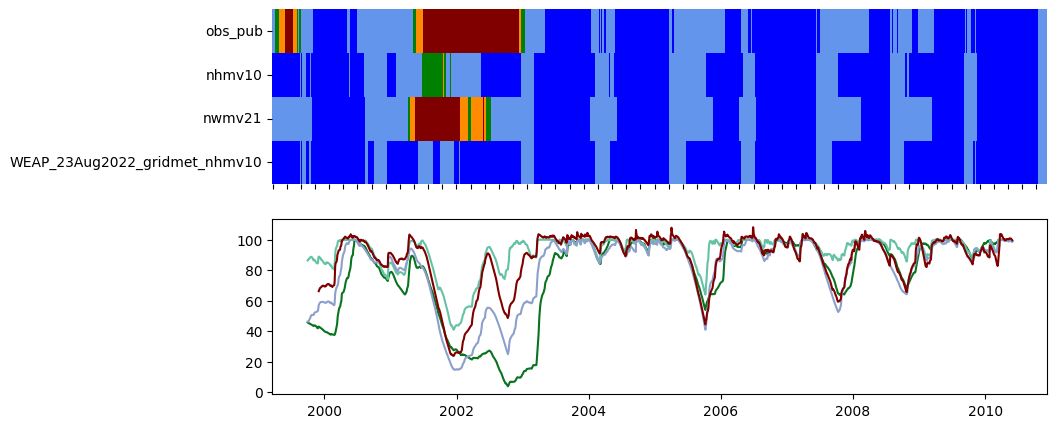

In [27]:
plot_combined_nyc_storage(storages, ['pywr_obs_pub', 'pywr_nhmv10','pywr_nwmv21'])

In [ ]:
def plot_stacked_storage(results, models, reservoir_list):
    """
    Stacked subplots of reservoir storages.
    
    Parameters:
    results : dictionary of storage results from `get_pywr_results`
    models : list of models to plot
    reservoir_list : list of reservoirs to plot
    """
    colordict = {'obs_pub':'#097320', 'nhmv10': '#66c2a5', 'nwmv21': '#8da0cb', 'nwmv21_withLakes': '#8da0cb', 'WEAP_23Aug2022_gridmet': '#fc8d62',
                 'pywr_obs_pub':'#097320', 'pywr_nhmv10': '#66c2a5', 'pywr_nwmv21': '#8da0cb', 'pywr_nwmv21_withLakes': '#8da0cb',
                 'pywr_WEAP_23Aug2022_gridmet_nhmv10': '#fc8d62'}
    
    # Create figure with m subplots
    fig, axs = plt.subplots(nrows=len(reservoir_list), ncols=1, figsize=(10, 5*len(reservoir_list)), sharex=True)

    # Plot each timeseries for each model
    lines = []
    for i, reservoir in enumerate(reservoir_list):
        for j, model in enumerate(models):
            line, = axs[i].plot(results[model][reservoir], color=colordict[model], label=model)
            if i == 0:
                lines.append(line)
        axs[i].set_ylabel(reservoir)
        axs[i].yaxis.set_label_coords(-0.1, 0.5) # Set y-axis label position
    
    
    fig.legend(lines, models)
    #fig.subplots_adjust(right=0.8)
    plt.xlabel('Date')
    plt.show()
    return

#fig.legend(lines, [f'Dataset {j+1}' for j in range(n_datasets)], loc='lower center', ncol=n_datasets)
